###  Centroid-based classification based on PCA

In [10]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import scipy.stats as st
from scipy import stats
from sklearn.neighbors import NearestCentroid
import numpy as np
import seaborn as sns

np.random.seed(41)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.set_figure_params(figsize=None)
RANDOM_SEED = 110011

In [3]:
# Read pre-processed data
save_file = '../data/h5ab_folder/gse159812_raw_covid_normalized_preprocessed.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
# Delete 'X_umap' for this experiment.
del adata.obsm['X_umap']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.obsm['X_pca']
del adata.uns['umap']
del adata.varm['PCs']
del adata.obsp

In [6]:
from sklearn.model_selection import train_test_split
list_samples = list(adata.obs['sample'].unique())
y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=110011)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train) # 4 samples
print("Samples for testing:", y_test) # 2 samples

Samples for getting centroids of existing samples (covid and non-covid): ['Control_9', 'COVID-19_3', 'Influenza_2', 'COVID-19_15', 'COVID-19_10', 'Control_4', 'Control_6', 'Control_7', 'Control_5', 'COVID-19_1', 'COVID-19_5', 'Control_2', 'COVID-19_9', 'Control_11', 'COVID-19_7', 'Control_8', 'COVID-19_14', 'COVID-19_11', 'COVID-19_8', 'COVID-19_13', 'COVID-19_6', 'Control_10', 'Control_3', 'Control_12']
Samples for testing: ['COVID-19_2', 'Control_13', 'Control_1', 'COVID-19_4', 'COVID-19_12', 'Influenza_1']


Make a copied adata. Then get the cell bercode corresponding to the samples of the train data.

In [7]:
### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_train'] = adata.obs['sample'].isin(y_train)

# Copy adata
adata_train = adata.copy()
# Remove cells that don't belong to y_train
adata_train = adata_train[adata_train.obs['contain_y_train'] == True,:]


### Make adata for train/existing data.
# Make a column that contains bool values based on whether the sample_name holds one of the samples in the y_train..
adata.obs['contain_y_test'] = adata.obs['sample'].isin(y_test)

# Copy adata
adata_test = adata.copy()
# Remove cells that don't belong to y_train
adata_test = adata_test[adata_test.obs['contain_y_test'] == True,:]

In [8]:
adata_train

View of AnnData object with n_obs × n_vars = 93881 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne'
    obsm: 'X_tsne'

In [9]:
adata_test

View of AnnData object with n_obs × n_vars = 20820 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'contain_y_train', 'contain_y_test'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'sample_colors', 'tsne'
    obsm: 'X_tsne'

Apply PCA to the train adata. Make sure both adata (train/refrence and test) have the same genes.

In [10]:
sc.pp.neighbors(adata_train, n_pcs = 30, n_neighbors = 20) 
sc.tl.pca(adata_train)
#sc.tl.umap(adata_train)
#sc.pl.umap(adata_train, color='sample')

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:09)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:45)


In [11]:
#sc.tl.ingest(adata_test, adata_train, obs='sample', embedding_method='umap')
sc.tl.ingest(adata_test, adata_train, embedding_method='pca')

running ingest
    finished (0:00:23)


/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


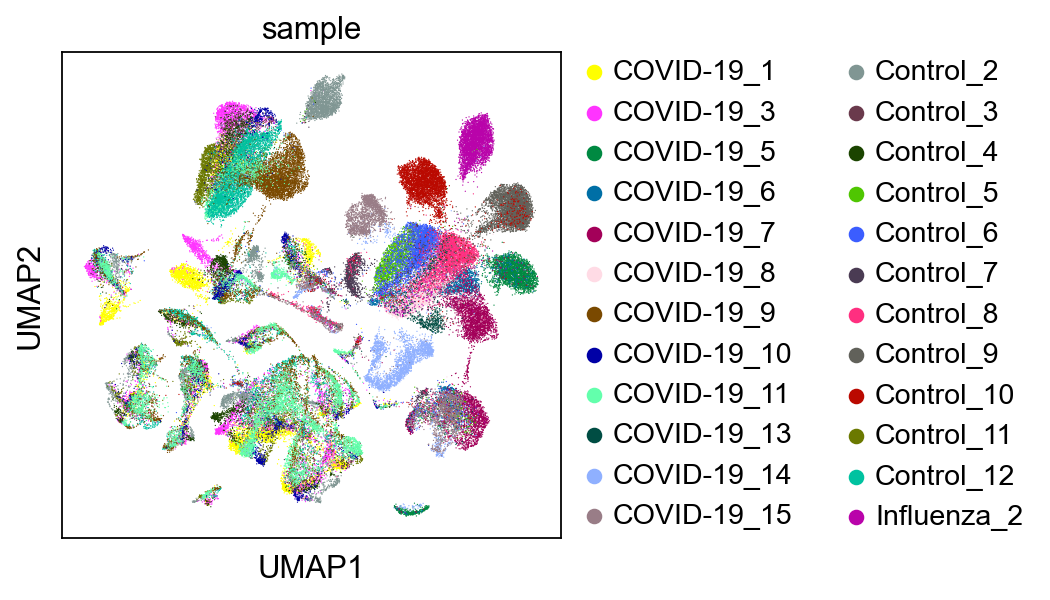

In [12]:
sc.pl.umap(adata_train, color='sample')

Concatenate both `adata_train` and `adata_test` for further analysis.

In [13]:
adata_concat = adata_train.concatenate(adata_test, batch_categories=['ref', 'new'])
adata = adata_concat.copy()

/opt/homebrew/Caskroom/miniforge/base/envs/scanpy_tutorial/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


### Read ingested and concatenated adata if we have done it before

In [3]:
# Read pre-processed data
save_file = '../data/h5ab_folder/ingest_gse159812_raw_covid_normalized_preprocessed_PCA.h5ad'
adata = sc.read_h5ad(save_file)
adata

AnnData object with n_obs × n_vars = 114701 × 2680
    obs: 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_id', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    obsm: 'X_pca', 'X_tsne'

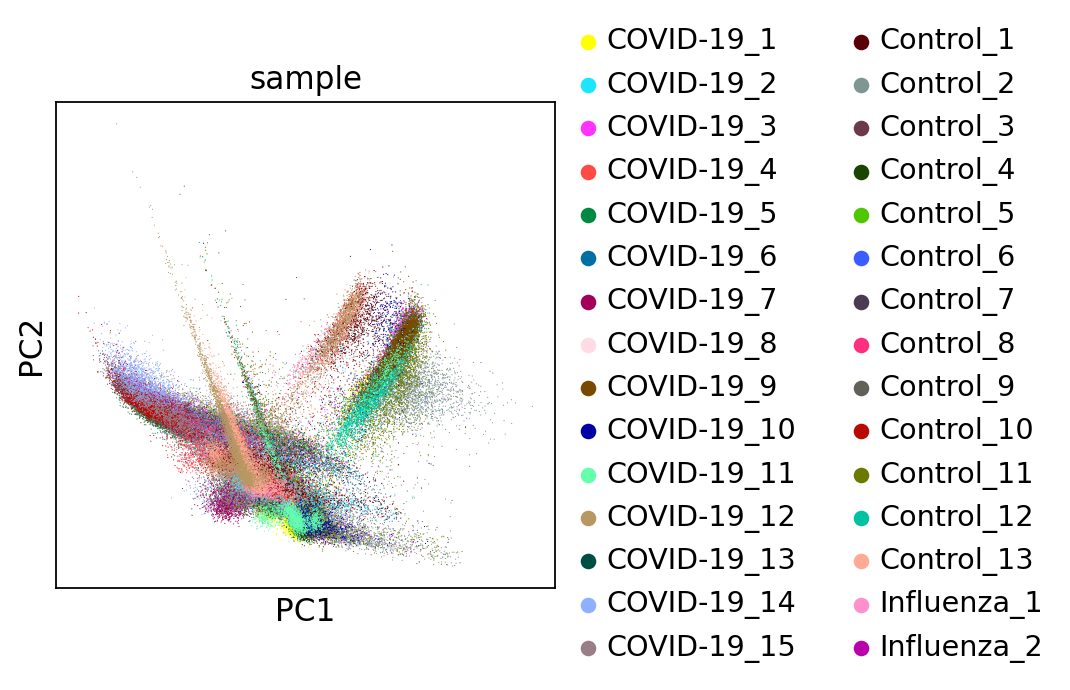

In [5]:
sc.pl.pca(adata, color='sample')

### Get centroids of each samples

In [6]:
basis_values = adata.obsm['X_pca'][:, :2]
sample_vector = adata.obs['sample'].values
x_basis_value = []
y_basis_value = []

for b_v in basis_values:
    x_basis_value.append(b_v[0])
    y_basis_value.append(b_v[1])

df = pd.DataFrame(list(zip(basis_values, sample_vector, x_basis_value, y_basis_value)),
               columns =['basis_value', 'sample', 'x_basis_value', 'y_basis_value'])
df.head()

X = np.stack(df.basis_value.values.tolist()[:])
y = df['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

#print("Centroids:", clf.centroids_)


NearestCentroid()

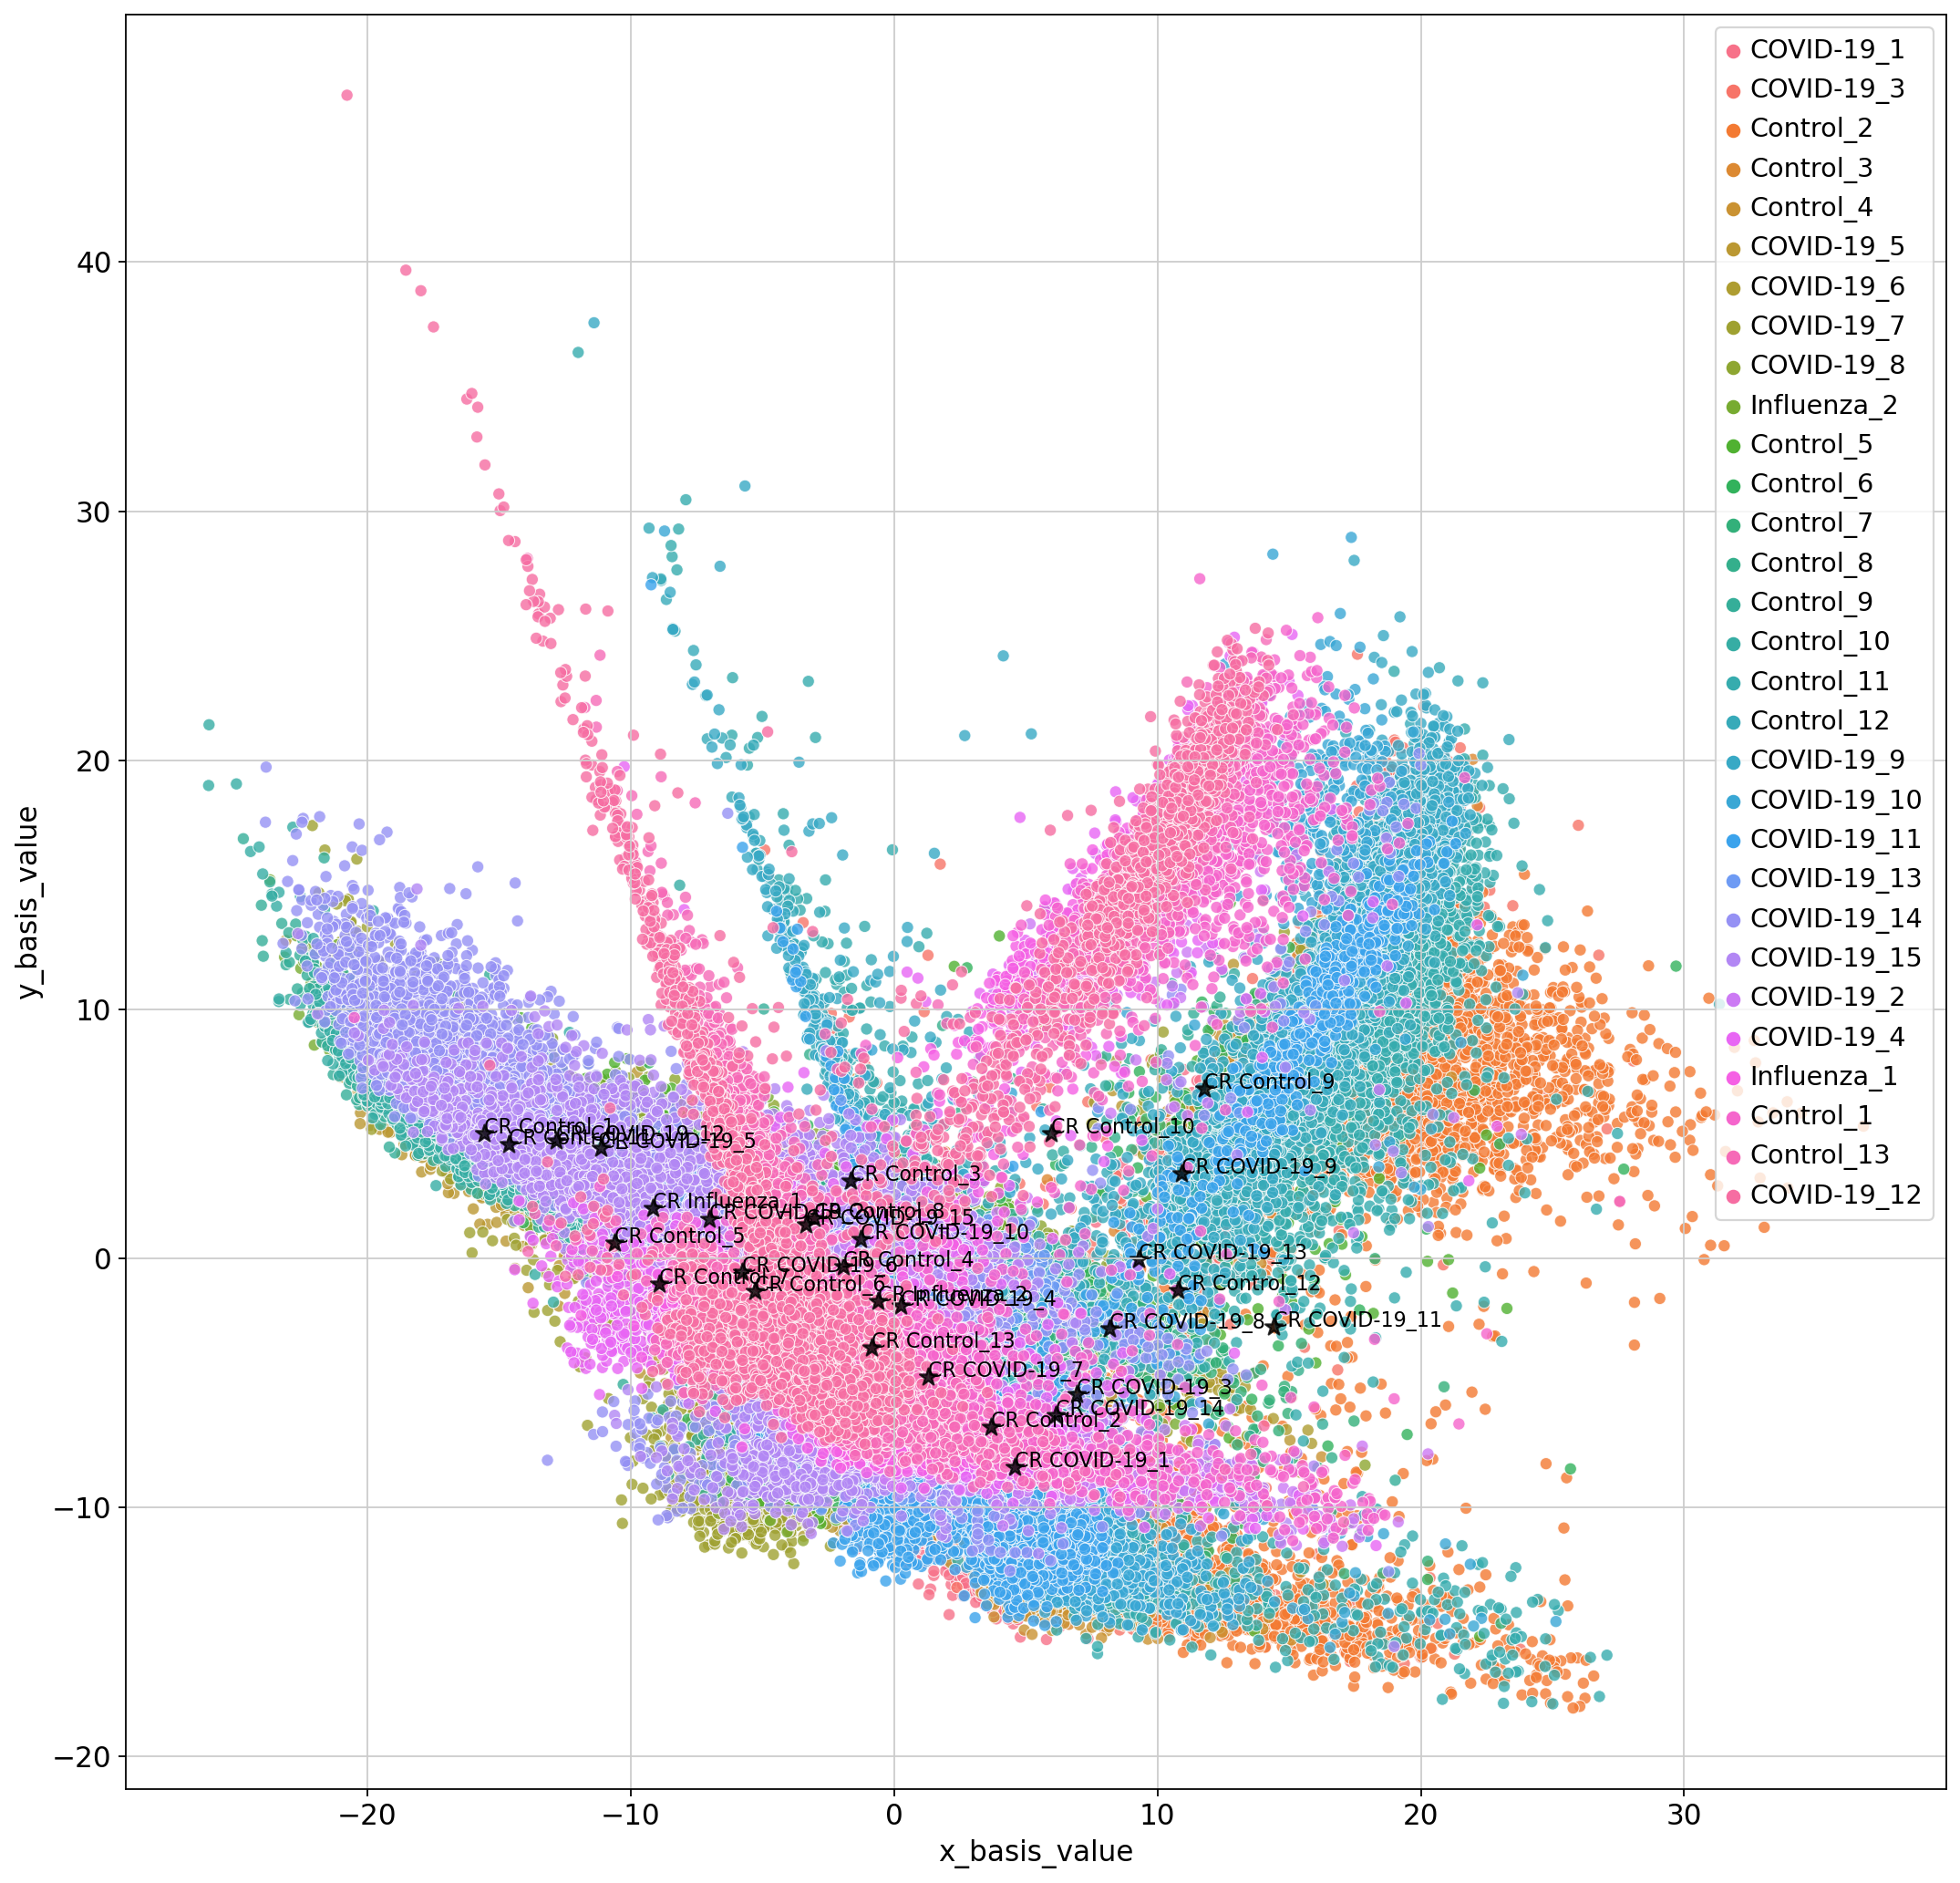

In [8]:
list_samples = df['sample'].unique()
sns.scatterplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', alpha=0.8)
#sns.lmplot(x='x_basis_value', y='y_basis_value', data=df, hue='sample', fit_reg=False)

centroid_id = 0
for centroid in clf.centroids_:
    plt.scatter(centroid[0], centroid[1], s=80, alpha=0.8, marker="*", color='black')
    plt.text(centroid[0], centroid[1], f'CR {list_samples[centroid_id]}', color='black', fontsize=10)
    centroid_id+= 1

# Show the plot
sc.set_figure_params(figsize=(16, 16))
plt.legend(loc="best")
plt.savefig("../output_pdfs/GSE159812_samples_centroids_PCA.pdf", format="pdf")
plt.show()

## Sample Classification: Scenario 2.1

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, count the nearest centroids of each cell in a new sample. And make a result based on the count (either `covid` or `non_covid`)

### Add a new columns: covid_non_covid to adata.obs

This allows us to visualize clusters in UMAP with only a covid patients and non-covid patients.

In [12]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(list_samples, test_size=0.20, random_state=RANDOM_SEED)

print("Samples for getting centroids of existing samples (covid and non-covid):", y_train)
print("Samples for testing:", y_test) 

Samples for getting centroids of existing samples (covid and non-covid): ['COVID-19_9' 'Control_2' 'Control_8' 'COVID-19_12' 'COVID-19_2'
 'COVID-19_8' 'Control_10' 'Control_11' 'Control_9' 'COVID-19_1'
 'Influenza_2' 'COVID-19_6' 'COVID-19_15' 'COVID-19_11' 'Control_6'
 'Control_12' 'Control_13' 'COVID-19_4' 'Control_7' 'Control_1'
 'Control_5' 'COVID-19_10' 'COVID-19_7' 'COVID-19_13']
Samples for testing: ['COVID-19_3' 'COVID-19_14' 'COVID-19_5' 'Control_3' 'Influenza_1'
 'Control_4']


In [13]:
y_train = list(y_train)
df_exist = df.query("sample == @y_train")
#df_exist

Get centroids of each existing samples.

In [14]:
X = np.stack(df_exist.basis_value.values.tolist()[:])
y = df_exist['sample'].tolist()
clf = NearestCentroid()
clf.fit(X, y)

NearestCentroid()

Get the nearest centroids with new samples.

In [15]:
y_test = list(y_test)
df_new = df.query("sample == @y_test")
#df_new

X_new = np.stack(df_new.basis_value.values.tolist()[:])
y_new = df_new['sample'].tolist()

y_pred = []
for x_new in X_new:
    y_pred.append(clf.predict([x_new]))

y_pred = np.squeeze(np.stack(y_pred[:]))

Count how many the nearest centroids of covid sample/non-covid samples has the new sample obtained.

In [16]:
from collections import Counter

beginning = 0
samples_range = dict()

y_pred_agg = []
y_true_agg = []
for sample in df_new['sample'].unique():
    # Assing a new label (either covid or non_covid sample))
    if 'covid' in sample or 'COVID' in sample: 
        y_true_agg.append('covid')
    else:
        y_true_agg.append('non_covid')
    samples_range[sample] = [beginning, beginning+len(df_new[df_new['sample'] == sample].index.to_list())]
    beginning = len(df_new[df_new['sample'] == sample].index.to_list())+beginning


# Get count of each new samples
for s, r in samples_range.items():
    print(f"Testing {s}")
    tmp_y_pred = y_pred[r[0]:r[1]]
    # count_detected_samples_key = list(Counter(tmp_y_pred).keys())
    # count_detected_samples = list(Counter(tmp_y_pred).values())
    count_pred_samples = Counter(tmp_y_pred)

    covid_sample_counter = 0
    non_covid_sample_counter = 0
    for s, count in count_pred_samples.items():
        if 'covid' in s or 'COVID' in s:
            covid_sample_counter+=count
        else:
            non_covid_sample_counter+=count
    
    if covid_sample_counter>non_covid_sample_counter:
        y_pred_agg.append('covid')
    else:
        y_pred_agg.append('non_covid')

Testing COVID-19_3
Testing Control_3
Testing Control_4
Testing COVID-19_5
Testing COVID-19_14
Testing Influenza_1


In [17]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_agg, y_pred_agg))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_agg, y_pred_agg,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_agg, y_pred_agg, average='micro'))

Accuracy: 0.16666666666666666
Precision: 0.16666666666666666
Recall: 0.16666666666666666


## Sample Classification: Scenario 2.2

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and ctrl samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids and then get distances between those existing samples and new samples. Then, sum the distances to the centroid of each new sample and the centroid of coronal and non-corona existing samples, separately for corona and non-corona. <br>
In the end, determine either the new sample is `covid` or `non_covid` based on the total distance with respect to covid and non-covid samples.

In [18]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

Calculate distance between new sample's centroids and exisitng one

In [19]:
print(exist_sample_centroids)
print()
print(new_sample_centroids)

[[  4.58959107  -8.3689598 ]
 [  6.95083164  -5.45748815]
 [  3.68753242  -6.75895433]
 [ -1.65029065   3.1167634 ]
 [ -1.91331372  -0.31490141]
 [ -5.7567489   -0.54703712]
 [  1.30672415  -4.74887757]
 [ -0.60534377  -1.73142852]
 [ -5.26770126  -1.31449342]
 [ -8.91807991  -1.03850535]
 [ -3.03305384   1.61185515]
 [ 11.78703617   6.80639457]
 [  5.95006369   5.00831645]
 [-14.63060708   4.57065874]
 [ 10.77349107  -1.28558097]
 [ 10.91669089   3.4049226 ]
 [ -1.26202892   0.77568553]
 [ 14.42066538  -2.73134185]
 [ -3.33475862   1.34609687]
 [ -7.00216561   1.57241969]
 [  0.27058184  -1.89502472]
 [ -9.14729841   1.99942591]
 [-15.56606261   4.99807578]
 [-12.82482356   4.73031428]]

[[-11.14608429   4.43203885]
 [  8.16921222  -2.83324309]
 [-10.60676186   0.60464636]
 [  9.27055777  -0.04450081]
 [  6.14787066  -6.29131919]
 [ -0.83795726  -3.59873118]]


In [20]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()

list_new_sample = df_new['sample'].unique()
# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: COVID-19_1
sample: COVID-19_3
20.284896984707423
sample: Control_3
6.592256602483408
sample: Control_4
17.64808063296544
sample: COVID-19_5
9.550291443511256
sample: COVID-19_14
2.5970802393095203
sample: Influenza_1
7.225881399246117
---------------------
Exist sample: Control_2
sample: COVID-19_3
20.622829843105595
sample: Control_3
2.8932876415033943
sample: Control_4
18.57467535600986
sample: COVID-19_5
5.889105296402286
sample: COVID-19_14
1.157592568341527
sample: Influenza_1
8.007509604100488
---------------------
Exist sample: COVID-19_6
sample: COVID-19_3
18.581563798052443
sample: Control_3
5.957907572945157
sample: Control_4
16.07947337886063
sample: COVID-19_5
8.732356963058358
sample: COVID-19_14
2.504385530036332
sample: Influenza_1
5.519698108114508
---------------------
Exist sample: COVID-19_7
sample: COVID-19_3
9.586451190755895
sample: Control_3
11.481516178364807
sample: Control_4
9.302102377161031
sample: COVID-19_5
11.3691917691

Get a label from checking the total distance of summing up the distance of exist covid sample and non covid sample between each ewn sample. <br>
<br>
And if the total distance to centroid with corona patient < the total distance to centroid with non corona patient<br>
-> The new sample is Corona (because the centroid of the new sample should be closer with the existing covid samples).<br>
Otherwise, The new sample is Non-covid.

In [21]:
covid_dist_total = 0
non_covid_dist_total = 0


new_dist_total = {s: {'covid': 0, 'non_covid': 0} for s in list_new_sample}

for i in range(len(list_exist_sample)):
    exist_sample = list_exist_sample[i]
    for new_s in dict_dist_results.keys():
        dist = dict_dist_results[new_s][i]
        if 'covid' in exist_sample or 'COVID' in exist_sample:
             new_dist_total[new_s]['covid'] += dist
        else:
            new_dist_total[new_s]['non_covid'] += dist

y_true_total_dist = []
y_pred_total_dist = []

for new_s, dist_total in new_dist_total.items():
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_total_dist.append('covid')
    else:
        y_true_total_dist.append('non_covid')

    # Compare the total distance to centroid with corona & non corona samples    
    if dist_total['covid'] < dist_total['non_covid']:
        y_pred_total_dist.append('covid')
    else:
        y_pred_total_dist.append('non_covid')

Get Acc, precision, recall, and f1 score.

In [22]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_total_dist, y_pred_total_dist))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_total_dist, y_pred_total_dist,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_total_dist, y_pred_total_dist, average='micro'))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5


## Sample Classification: Scenario 2.3

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and non-covid samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get the nearest centroids, and determine whether the new sample is covid or non_covid based on the nearest sample's centroid.

In [23]:
df

,basis_value,sample,x_basis_value,y_basis_value
0,"[3.7533211708068848, -13.429734230041504]",COVID-19_1,3.753321,-13.429734
1,"[3.979201555252075, -12.973167419433594]",COVID-19_1,3.979202,-12.973167
2,"[1.532645344734192, -9.951640129089355]",COVID-19_1,1.532645,-9.951640
3,"[0.575897753238678, -8.628656387329102]",COVID-19_1,0.575898,-8.628656
4,"[3.398256540298462, -12.020442962646484]",COVID-19_1,3.398257,-12.020443
...,...,...,...,...
114696,"[8.101748543398035, 13.275000602768772]",COVID-19_12,8.101749,13.275001
114697,"[-11.124620946498428, 18.713409963723393]",COVID-19_12,-11.124621,18.713410
114698,"[-1.3863679180231596, -5.933936059492354]",COVID-19_12,-1.386368,-5.933936
114699,"[-6.08839628749764, 11.881802966568767]",COVID-19_12,-6.088396,11.881803


In [24]:
# Get a centroid of each sample
clf_new = NearestCentroid()
clf_new.fit(X_new, y_new)

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_

# result_dict = dict(zip(np.unique(np.array(y_new)),clf_new.centroids_))
# print(result_dict)

In [25]:
distances = []

exist_sample_centroids = clf.centroids_
new_sample_centroids = clf_new.centroids_
list_exist_sample = df_exist['sample'].unique()
list_new_sample = df_new['sample'].unique()

# using zip() function to create a dictionary
# with keys and same length None value
dict_dist_results = {s: [] for s in list_new_sample}
# print(dict_dist_results)

for i in range(len(exist_sample_centroids)):
    print("---------------------")
    print("Exist sample:", list_exist_sample[i])
    #sample_key = list_exist_sample[i]
    for j in range (len(new_sample_centroids)):
        sample = list_new_sample[j]
        print('sample:', list_new_sample[j])
        dist = np.linalg.norm(np.array(exist_sample_centroids[i]) - np.array(new_sample_centroids[j]))
        print(dist)
        dict_dist_results[sample].append(dist)

---------------------
Exist sample: COVID-19_1
sample: COVID-19_3
20.284896984707423
sample: Control_3
6.592256602483408
sample: Control_4
17.64808063296544
sample: COVID-19_5
9.550291443511256
sample: COVID-19_14
2.5970802393095203
sample: Influenza_1
7.225881399246117
---------------------
Exist sample: Control_2
sample: COVID-19_3
20.622829843105595
sample: Control_3
2.8932876415033943
sample: Control_4
18.57467535600986
sample: COVID-19_5
5.889105296402286
sample: COVID-19_14
1.157592568341527
sample: Influenza_1
8.007509604100488
---------------------
Exist sample: COVID-19_6
sample: COVID-19_3
18.581563798052443
sample: Control_3
5.957907572945157
sample: Control_4
16.07947337886063
sample: COVID-19_5
8.732356963058358
sample: COVID-19_14
2.504385530036332
sample: Influenza_1
5.519698108114508
---------------------
Exist sample: COVID-19_7
sample: COVID-19_3
9.586451190755895
sample: Control_3
11.481516178364807
sample: Control_4
9.302102377161031
sample: COVID-19_5
11.3691917691

In [26]:
dict_nearest_dist_idex = dict()
y_true_nearest = []
y_pred_nearest = []

for new_s, coords_centroid in dict_dist_results.items():
    nearest_sample_index = np.argmin(np.array(coords_centroid))
    nearest_sample = list_exist_sample[nearest_sample_index]

    # Assign a label to y_true
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_nearest.append('covid')
    else:
        y_true_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the nearest sample by distance
    if 'covid' in nearest_sample or 'COVID' in nearest_sample:
        y_pred_nearest.append('covid')
    else:
        y_pred_nearest.append('non_covid')


In [27]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_nearest, y_pred_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_nearest, y_pred_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_nearest, y_pred_nearest, average='micro'))

Accuracy: 0.8333333333333334
Precision: 0.8333333333333334
Recall: 0.8333333333333334


## Sample Classification: Scenario 2.4

### Input data
UMAP representation (UMAP 1 - UMAP 2)

### Method
Get centroids of each sample's cluster (covid and non-covid samples). When we get a new sample, we compute a centroid of each new sample. And compare them with those existing samples' centroids, get k nearest centroids, and determine whether the new sample is covid or non_covid based on k nearest sample's centroid.

#### k=3

In [28]:
dict_nearest_dist_idex = dict()
y_true_k_nearest = []
y_pred_k_nearest = []
k = 3

# Get the k nearest samples
for new_s, coords_centroid in dict_dist_results.items():
    k_nearest_sample_index = np.argsort(coords_centroid)[:k]
    nearest_samples = list_exist_sample[k_nearest_sample_index]
    
    # Assign a label to y_true
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_k_nearest.append('covid')
    else:
        y_true_k_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the count of k nearest samples.
    covid_count = 0
    non_covid_count = 0

    for item in nearest_samples:
        if 'COVID' in item or 'covid' in item:
            covid_count += 1
        else:
            non_covid_count += 1
    
    if covid_count > non_covid_count:
        y_pred_k_nearest.append('covid')
    else:
        y_pred_k_nearest.append('non_covid')

In [29]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_k_nearest, y_pred_k_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_k_nearest, y_pred_k_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

print("f1 score:", metrics.f1_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

Accuracy: 0.6666666666666666
Precision: 0.6666666666666666
Recall: 0.6666666666666666
f1 score: 0.6666666666666666


In [30]:
dict_nearest_dist_idex = dict()
y_true_k_nearest = []
y_pred_k_nearest = []
k = 5

# Get the k nearest samples
for new_s, coords_centroid in dict_dist_results.items():
    k_nearest_sample_index = np.argsort(coords_centroid)[:k]
    nearest_samples = list_exist_sample[k_nearest_sample_index]
    
    # Assign a label to y_true
    if 'covid' in new_s or 'COVID' in new_s:
        y_true_k_nearest.append('covid')
    else:
        y_true_k_nearest.append('non_covid')
    
    # Assign a label to y_pred based on the count of k nearest samples.
    covid_count = 0
    non_covid_count = 0

    for item in nearest_samples:
        if 'COVID' in item or 'covid' in item:
            covid_count += 1
        else:
            non_covid_count += 1
    
    if covid_count > non_covid_count:
        y_pred_k_nearest.append('covid')
    else:
        y_pred_k_nearest.append('non_covid')

In [31]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_true_k_nearest, y_pred_k_nearest))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_true_k_nearest, y_pred_k_nearest,  average='micro'))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

print("f1 score:", metrics.f1_score(y_true_k_nearest, y_pred_k_nearest, average='micro'))

Accuracy: 0.5
Precision: 0.5
Recall: 0.5
f1 score: 0.5
